link do colaba: https://colab.research.google.com/drive/16NGofSSUMOWQQFJju8TfoAbszPrZuMpP?usp=sharing

<h1>ZMGSN Lista 2. - Variational Autoencoder (VAE)</h1>

<h2>Opis zadania</h2>

W ramach zadania należy:
<ol>
<li>Zapoznać się z poniższym eksperymentem z wykorzystaniem modelu VAE</li>
<li>Dokonać analizy wpływu hiperparametrów eksperymentu, np. kroku uczenia, rozmiaru pakietu (ang. <i>batch size</i>), liczby epok na wyniki modelu VAE</li>
<li>Zaimplementować koder (ang. encoder) kompatybilny z dekoderem wykorzystanym w poniższym eksperymencie</li>
<li>Połączyć zaimplementowany koder z dostępnym dekoderem w celu opracowania autokodera (ang. autoencoder - AE)</li>
<li>Opracować pętlę uczącą dopasowaną do sieci typu Autoencoder</li>
<li>Dokonać ewaluacji opracowanej sieci typu Autoencoder</li>
<li>Porównać wyniki działania modelu AE z modelem VAE</li>
<li>Dokonać ewaluacji innych wariantów sieci VAE, np. Concrete VAE, BVAE, NVAE itp.</li>
<li>Opracować procedurę ewaluacji jakości działania modeli AE, VAE i innych rozważanych wariantów, uwzględniającą różne metody wizualizacji (np. wykresy, miary, klasy), klasteryzacji, redukcji wymiarów (np. t-SNE)</li>
</ol>

Ocenie podlegać będzie jakość wykonania zadania, w tym:
<ol>
<li>Właściwe wykonanie zadań</li>
<li>Rzetelne opracowanie wyników, uwzględniające analizę jakościową i ilościową</li>
<li>Opracowanie wniosków mających na celu wyjaśnienie badanych zjawisk i uzyskanych wyników</li>
<li>Opracowanie i wyjaśnienie kodu źródłowego</li>
</ol>


<h2>Import używanych bibliotek</h2>

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils
import torch.distributions
import torchvision
import pandas as pd
import plotly.express as px

<h2>Inicjalizacja ziarna generatora liczb pseudolosowych</h2>

In [ ]:
torch.manual_seed(0)

<h2>Konfiguracja stylu prezentacji wykresów generowanych za pomocą biblioteki Matplotlib</h2>

In [ ]:
plt.rcParams['figure.dpi'] = 200

<h2>Określenie domyślnego urządzenia na podstawie sprawdzenia dostępności karty graficznej</h2>

In [ ]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

<h2>Określenie wymiarowości ukrytej przestrzeni wektorowej, w której będą przechowywane ukryte reprezentacje danych wejściowych</h2>

In [ ]:
latent_dims = 2

<h2>Pobranie i rozpakowanie zbioru danych</h2>

In [ ]:
data = torch.utils.data.DataLoader(
        torchvision.datasets.MNIST('./data',
               transform=torchvision.transforms.ToTensor(),
               download=True),
        batch_size=64,
        shuffle=True)

100%|██████████| 9912422/9912422 [00:00<00:00, 134602371.31it/s]

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw


100%|██████████| 28881/28881 [00:00<00:00, 24501556.19it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 32400370.09it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw


100%|██████████| 4542/4542 [00:00<00:00, 3134857.46it/s]


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



<h2>Deklaracja podstawowej klasy kodera wariacyjnego (ang. variational encoder)<h2>

In [ ]:
class VariationalEncoder(nn.Module):
    def __init__(self, latent_dims):
        super(VariationalEncoder, self).__init__()
        self.linear1 = nn.Linear(784, 512)
        self.linear2 = nn.Linear(512, latent_dims)
        self.linear3 = nn.Linear(512, latent_dims)

        self.N = torch.distributions.Normal(0, 1)
        # umożliwienie próbkowania wielowymiarowego rozkładu na karcie graficznej
        self.N.loc = self.N.loc.cuda() if torch.cuda.is_available() else self.N.loc
        self.N.scale = self.N.scale.cuda() if torch.cuda.is_available() else self.N.scale
        self.kl = 0

    def forward(self, x):
        x = torch.flatten(x, start_dim=1)
        x = F.relu(self.linear1(x))
        mu =  self.linear2(x)
        sigma = torch.exp(self.linear3(x))
        z = mu + sigma*self.N.sample(mu.shape)
        self.kl = (((sigma**2 + mu**2) / 2) - torch.log(sigma) - 1/2).sum()
        return z

class Decoder(nn.Module):
    def __init__(self, latent_dims):
        super(Decoder, self).__init__()
        self.linear1 = nn.Linear(latent_dims, 512)
        self.linear2 = nn.Linear(512, 784)

    def forward(self, z):
        z = F.relu(self.linear1(z))
        z = torch.sigmoid(self.linear2(z))
        return z.reshape((-1, 1, 28, 28))

<h2>Deklaracja podstawowej klasy wariacyjnego autokodera (ang. variational autoencoder - VAE)</h2>

In [ ]:
class VariationalAutoencoder(nn.Module):
    def __init__(self, latent_dims):
        super(VariationalAutoencoder, self).__init__()
        self.encoder = VariationalEncoder(latent_dims)
        self.decoder = Decoder(latent_dims)

    def forward(self, x):
        z = self.encoder(x)
        return self.decoder(z)

<h2>Przykładowa pętla ucząca</h2>

In [ ]:
def train(autoencoder, data, epochs=20):
    opt = torch.optim.Adam(autoencoder.parameters())
    losses = []
    for epoch in range(epochs):
        loss_list = np.array([])
        for x, y in data:
            x = x.to(device)
            opt.zero_grad()
            x_hat = autoencoder(x)
            loss = ((x - x_hat)**2).sum() + autoencoder.encoder.kl
            loss.backward()
            opt.step()
            loss_list = np.append(loss_list, loss.item())
        print(f"Epoch [{epoch+1}/{epochs}], avg_loss: {np.mean(loss_list):.4f}")
        losses.append(round(np.mean(loss_list),4))
    return autoencoder, losses

<h2>Inicjalizacja sieci VAE i uruchomienie procesu uczenia</h2>

In [ ]:
vae = VariationalAutoencoder(latent_dims).to(device)
vae, loses_vae = train(vae, data)

Epoch [1/20], avg_loss: 2901.7678
Epoch [2/20], avg_loss: 2628.4072
Epoch [3/20], avg_loss: 2575.3548
Epoch [4/20], avg_loss: 2542.5911
Epoch [5/20], avg_loss: 2518.4252
Epoch [6/20], avg_loss: 2498.3501
Epoch [7/20], avg_loss: 2484.2184
Epoch [8/20], avg_loss: 2468.2803
Epoch [9/20], avg_loss: 2455.0361
Epoch [10/20], avg_loss: 2445.6299
Epoch [11/20], avg_loss: 2434.5591
Epoch [12/20], avg_loss: 2427.1010
Epoch [13/20], avg_loss: 2420.2771
Epoch [14/20], avg_loss: 2411.8913
Epoch [15/20], avg_loss: 2405.4444
Epoch [16/20], avg_loss: 2398.4976
Epoch [17/20], avg_loss: 2392.8529
Epoch [18/20], avg_loss: 2387.4911
Epoch [19/20], avg_loss: 2382.9660
Epoch [20/20], avg_loss: 2377.5874


## Fcje pomocnicze

<h2>Funkcja pomocniczna służąca do wizualizacji ukrytej wektorowej reprezentacji (ang. latent vector) danych wejściowych</h2>

In [ ]:
def plot_latent(autoencoder, data, num_batches=100):
    plt.figure(figsize = (4.5,3.5))
    for i, (x, y) in enumerate(data):
        z = autoencoder.encoder(x.to(device))
        z = z.to('cpu').detach().numpy()

        plt.scatter(z[:, 0], z[:, 1], c=y, cmap='tab10', s=0.8)
        if i > num_batches:
            plt.colorbar()
            break

<h2>Funkcja pomocniczna służąca do jednostajnego próbkowania wyuczonej przestrzeni wektorowej (ang. latent vector space), z której sieć VAE czerpie ukryte reprezentacje wektorowe danych wejściowych</h2>

In [ ]:
def plot_reconstructed(autoencoder, r0=(-5, 10), r1=(-10, 5), n=12):
    w = 28
    img = np.zeros((n*w, n*w))
    for i, y in enumerate(np.linspace(*r1, n)):
        for j, x in enumerate(np.linspace(*r0, n)):
            z = torch.Tensor([[x, y]]).to(device)
            x_hat = autoencoder.decoder(z)
            x_hat = x_hat.reshape(28, 28).to('cpu').detach().numpy()
            img[(n-1-i)*w:(n-1-i+1)*w, j*w:(j+1)*w] = x_hat
    plt.figure(figsize = (4,3))
    plt.imshow(img, extent=[*r0, *r1])

<h2>Funkcja pomocnicza pozwalająca na interpolację</h2>

In [ ]:
def interpolate(autoencoder, x_1, x_2, n=12):
    z_1 = autoencoder.encoder(x_1)
    z_2 = autoencoder.encoder(x_2)
    z = torch.stack([z_1 + (z_2 - z_1)*t for t in np.linspace(0, 1, n)])
    interpolate_list = autoencoder.decoder(z)
    interpolate_list = interpolate_list.to('cpu').detach().numpy()

    w = 28
    img = np.zeros((w, n*w))
    for i, x_hat in enumerate(interpolate_list):
        img[:, i*w:(i+1)*w] = x_hat.reshape(28, 28)
    plt.imshow(img)
    plt.xticks([])
    plt.yticks([])

#Hiperparams evaluation

##Epochs

### Epochs = 10

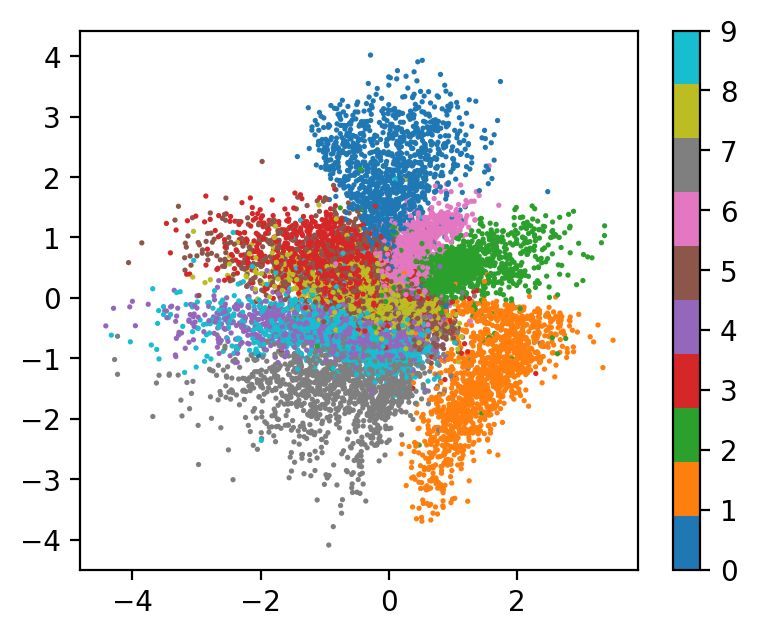

In [ ]:
plot_latent(vae_e_10, data)

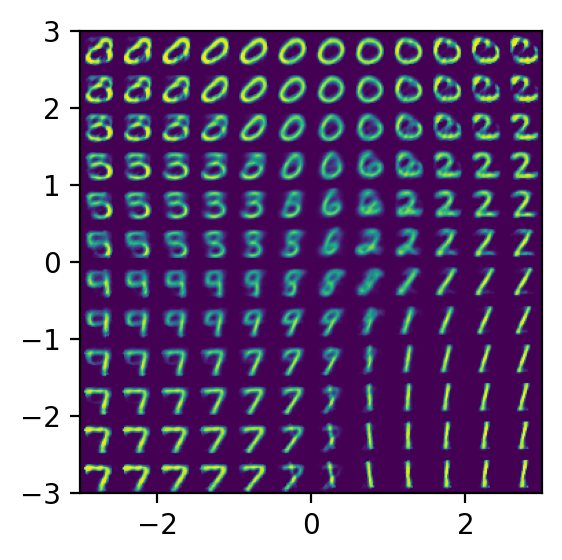

In [ ]:
plot_reconstructed(vae_e_10, r0=(-3, 3), r1=(-3, 3))

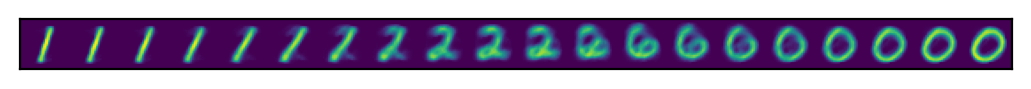

In [ ]:
# Uzyskanie pakietu próbek (ang. batch) ze zbioru uczącego
# x, y = data.__iter__().next()
x, y = next(iter(data))

# Uzyskanie próbki należącej do klasy "1"
x_1 = x[y == 1][1].to(device)

# Uzyskanie próbki należącej do klasy "0"
x_2 = x[y == 0][1].to(device)

interpolate(vae_e_10, x_1, x_2, n=20)

### Epochs=20

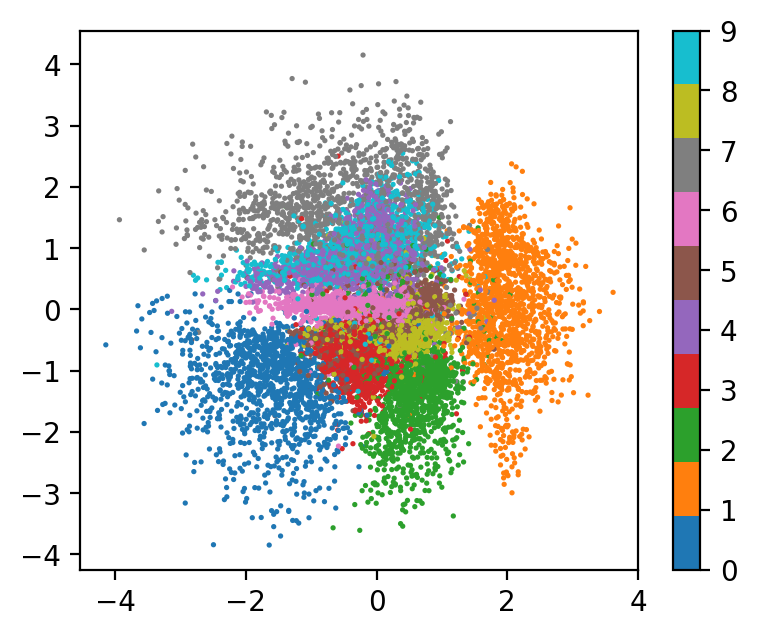

In [ ]:
plot_latent(vae_e_20, data)

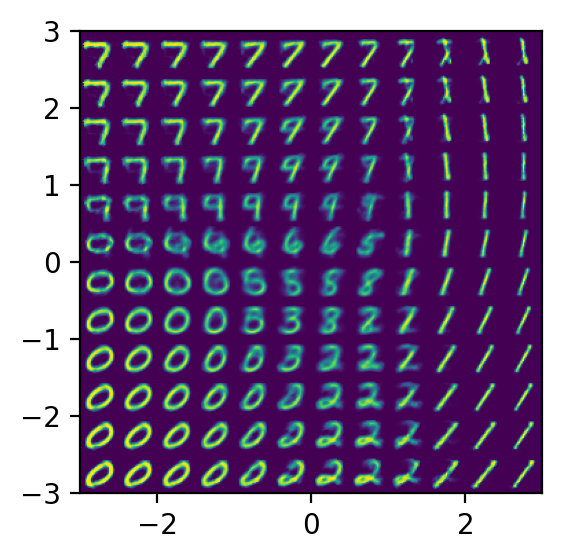

In [ ]:
plot_reconstructed(vae_e_20, r0=(-3, 3), r1=(-3, 3))

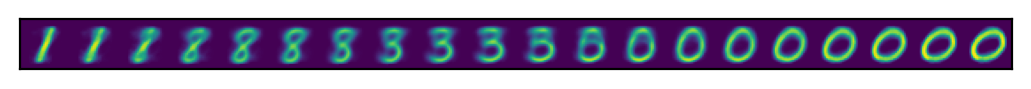

In [ ]:
x, y = next(iter(data))
x_1 = x[y == 1][1].to(device)
x_2 = x[y == 0][1].to(device)

interpolate(vae_e_20, x_1, x_2, n=20)

### Epochs=30

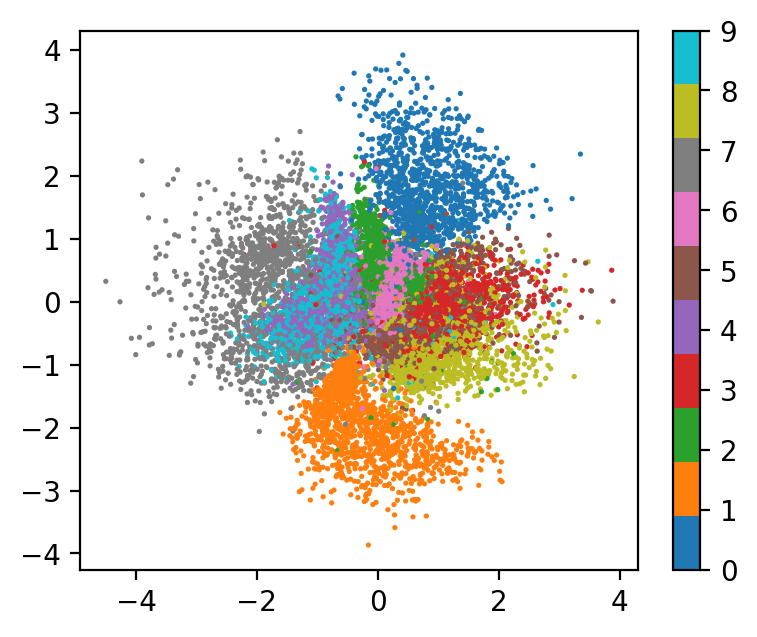

In [ ]:
plot_latent(vae_e_30, data)

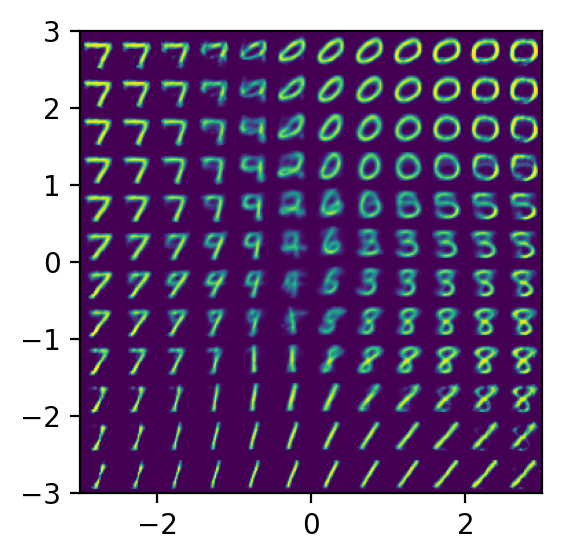

In [ ]:
plot_reconstructed(vae_e_30, r0=(-3, 3), r1=(-3, 3))

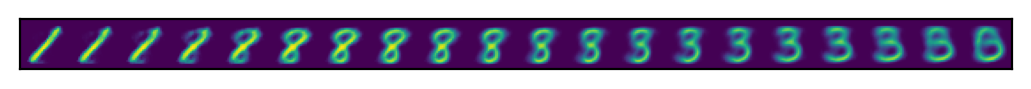

In [ ]:
x, y = next(iter(data))
x_1 = x[y == 1][1].to(device)
x_2 = x[y == 0][1].to(device)

interpolate(vae_e_30, x_1, x_2, n=20)

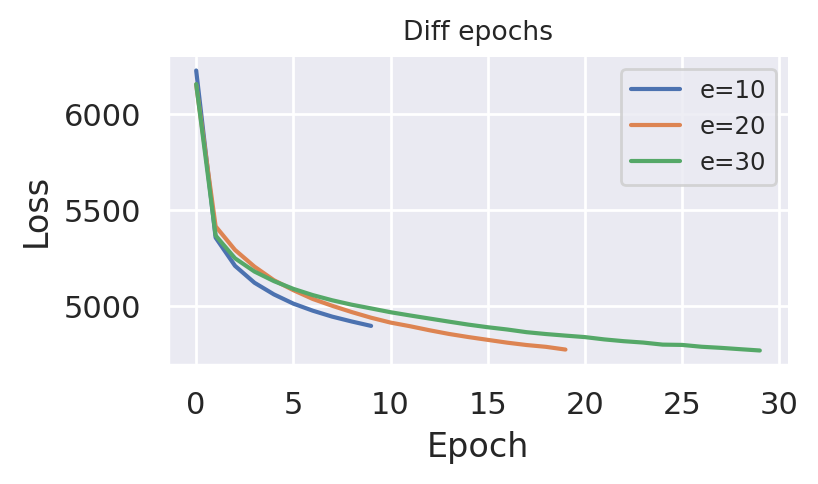

In [ ]:
import plotly.express as px
import pandas as pd
import seaborn as sns

plt.figure(figsize=(4, 2))
sns.set(style="darkgrid")

sns.lineplot(x=range(len(loses_e_10)), y=loses_e_10, label='e=10')
sns.lineplot(x=range(len(loses_e_20)), y=loses_e_20, label='e=20')
sns.lineplot(x=range(len(loses_e_30)), y=loses_e_30, label='e=30')

sns.despine()

plt.title('Diff epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

##Batch sizes

### Batch size = 32

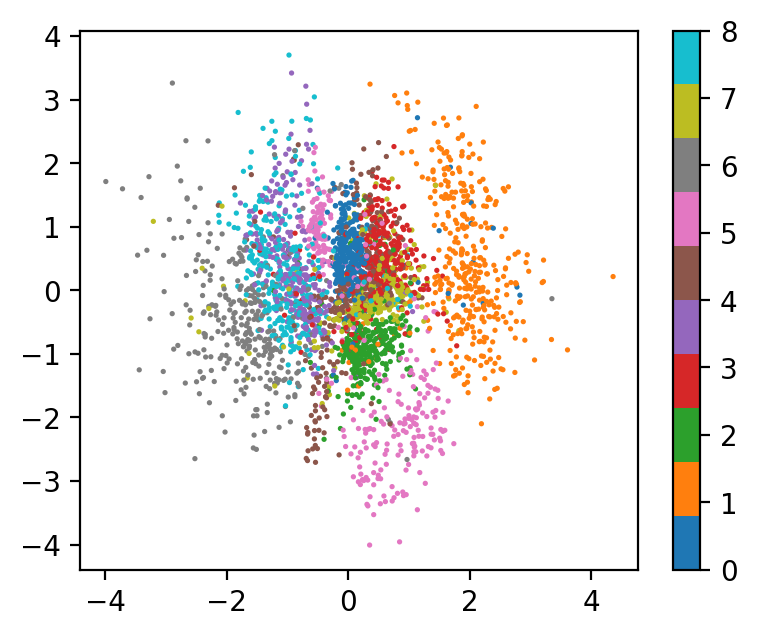

In [ ]:
plot_latent(vae_bs_32, data)

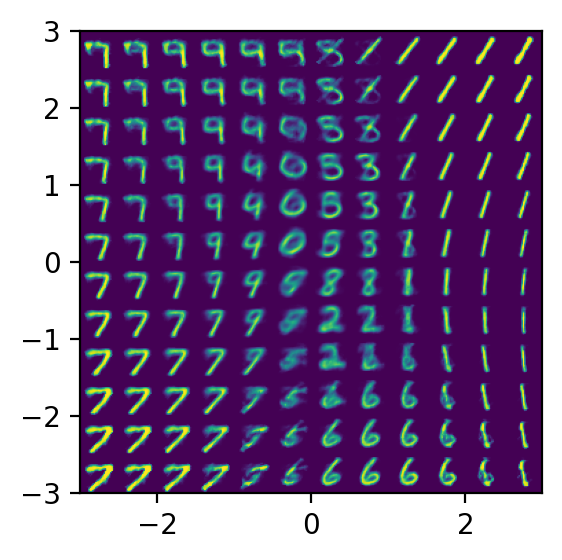

In [ ]:
plot_reconstructed(vae_bs_32, r0=(-3, 3), r1=(-3, 3))

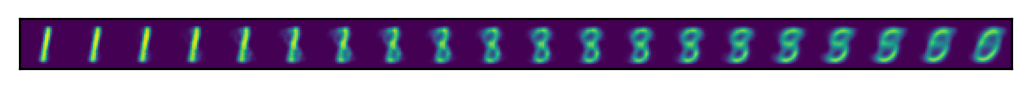

In [ ]:
x, y = next(iter(data))
x_1 = x[y == 1][1].to(device)
x_2 = x[y == 0][1].to(device)

interpolate(vae_bs_32, x_1, x_2, n=20)

### Batch size = 64

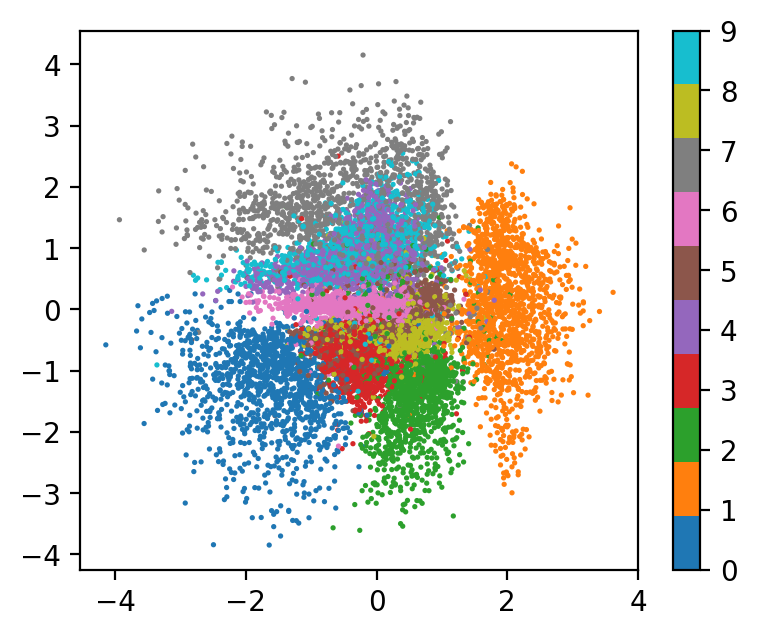

In [ ]:
plot_latent(vae_e_20, data)

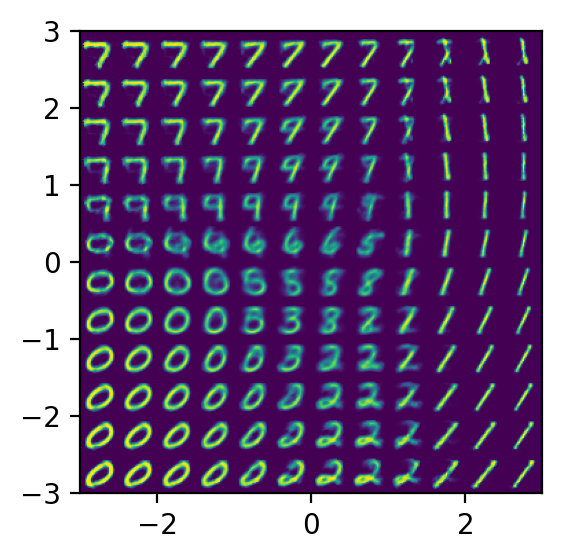

In [ ]:
plot_reconstructed(vae_e_20, r0=(-3, 3), r1=(-3, 3))

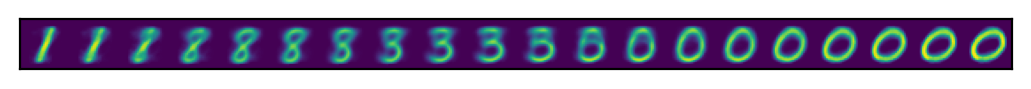

In [ ]:
x, y = next(iter(data))
x_1 = x[y == 1][1].to(device)
x_2 = x[y == 0][1].to(device)

interpolate(vae_e_20, x_1, x_2, n=20)

### Batch size = 128

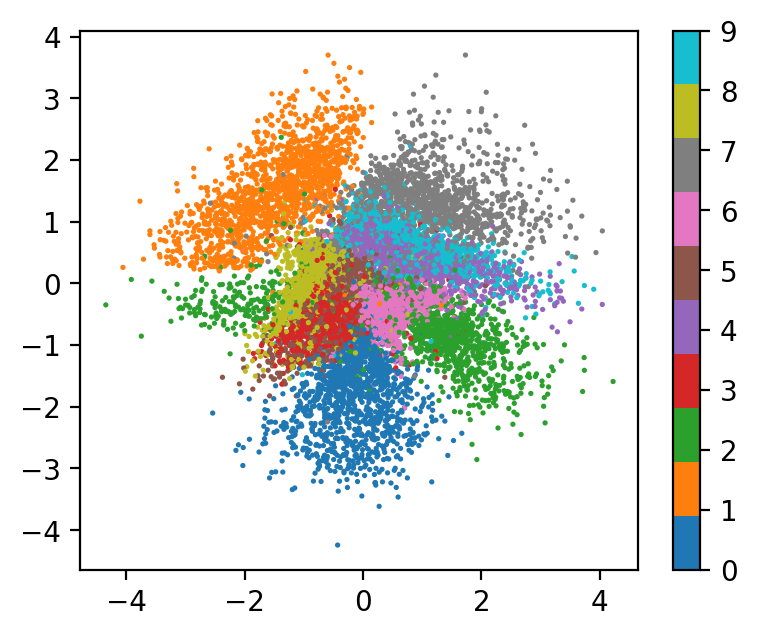

In [ ]:
plot_latent(vae_bs_128, data)

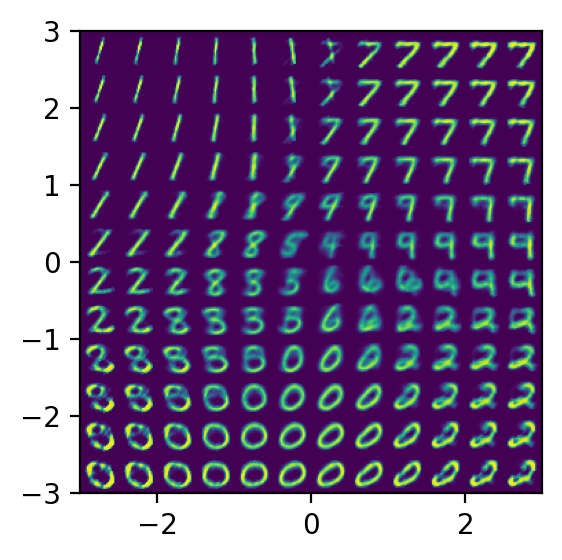

In [ ]:
plot_reconstructed(vae_bs_128, r0=(-3, 3), r1=(-3, 3))

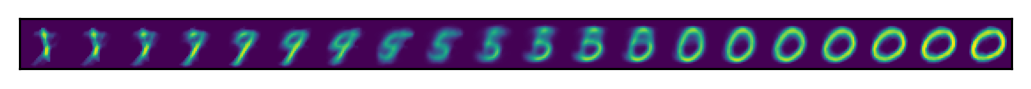

In [ ]:
x, y = next(iter(data))
x_1 = x[y == 1][1].to(device)
x_2 = x[y == 0][1].to(device)

interpolate(vae_bs_128, x_1, x_2, n=20)

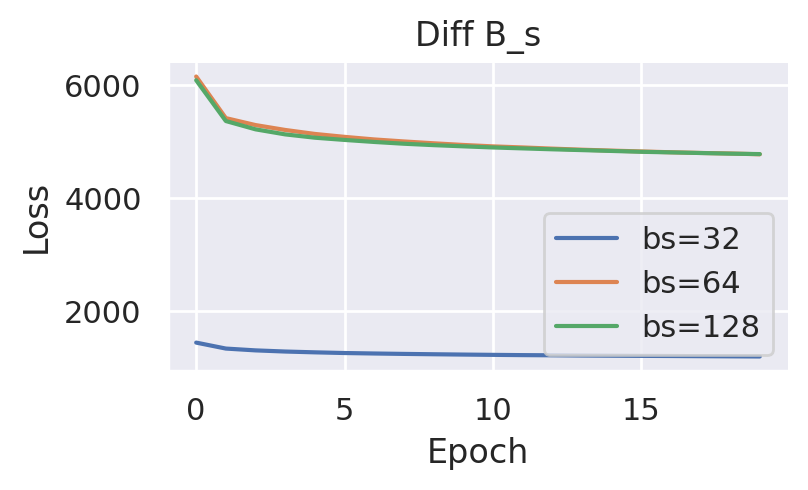

In [ ]:
df = pd.DataFrame({
    'bs=32': loses_bs_32,
    'bs=64': loses_e_20,
    'bs=128': loses_bs_128
})
plt.figure(figsize=(4, 2))
sns.set(style="darkgrid")

sns.lineplot(x=range(20), y=loses_bs_32, label='bs=32')
sns.lineplot(x=range(20), y=loses_e_20, label='bs=64')
sns.lineplot(x=range(20), y=loses_bs_128, label='bs=128')

sns.despine()

plt.title('Diff B_s')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

##Learning rates

### L_r = 0.01

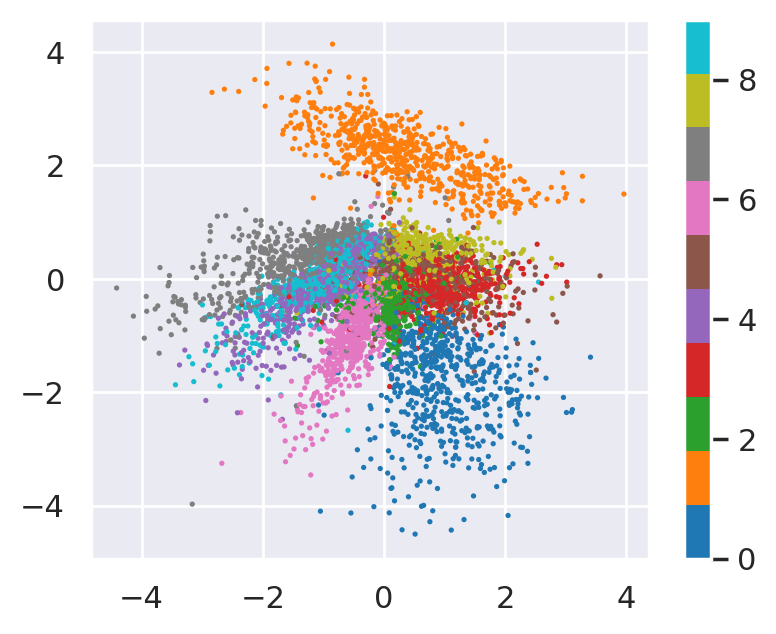

In [ ]:
plot_latent(vae_lr_1, data)

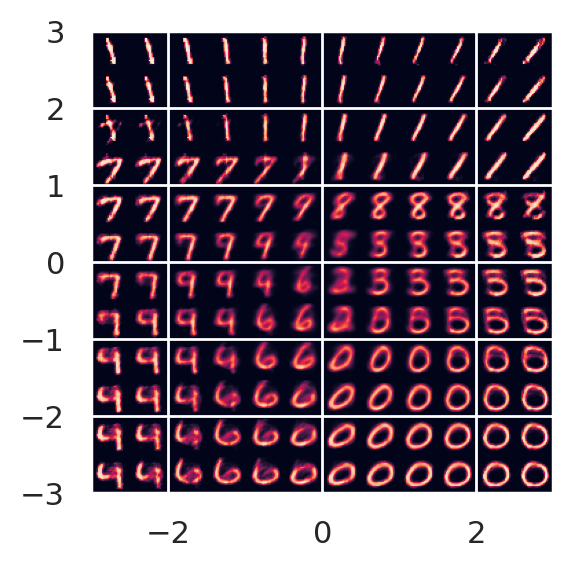

In [ ]:
plot_reconstructed(vae_lr_1, r0=(-3, 3), r1=(-3, 3))

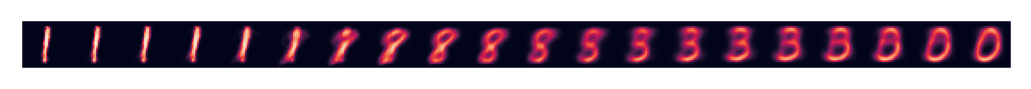

In [ ]:
x, y = next(iter(data))
x_1 = x[y == 1][1].to(device)
x_2 = x[y == 0][1].to(device)

interpolate(vae_lr_1, x_1, x_2, n=20)

### L_r = 0.001

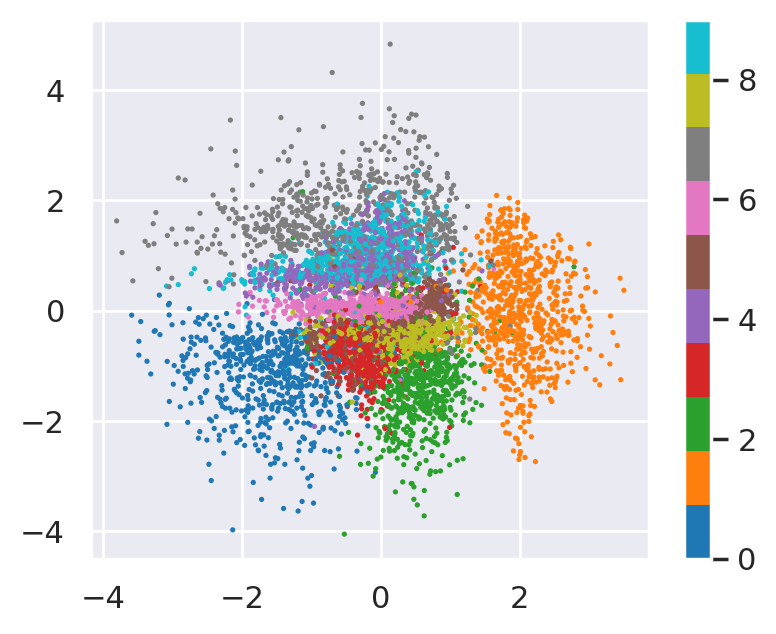

In [ ]:
plot_latent(vae_e_20, data)

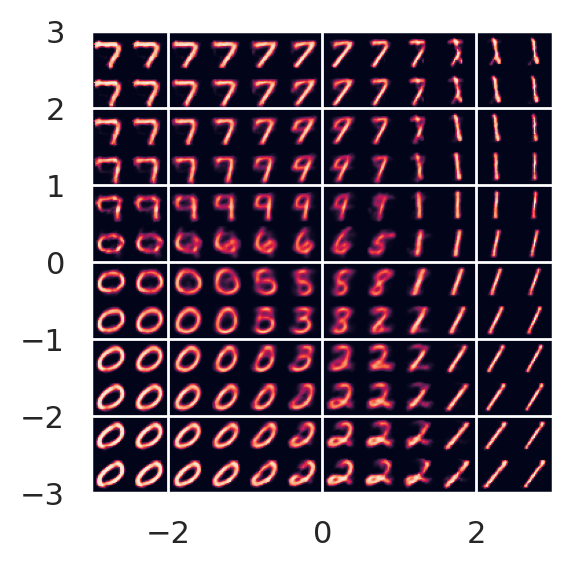

In [ ]:
plot_reconstructed(vae_e_20, r0=(-3, 3), r1=(-3, 3))

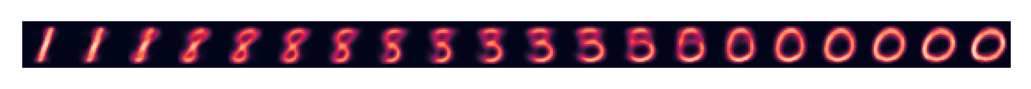

In [ ]:
x, y = next(iter(data))
x_1 = x[y == 1][1].to(device)
x_2 = x[y == 0][1].to(device)

interpolate(vae_e_20, x_1, x_2, n=20)

### L_r = 0.0005

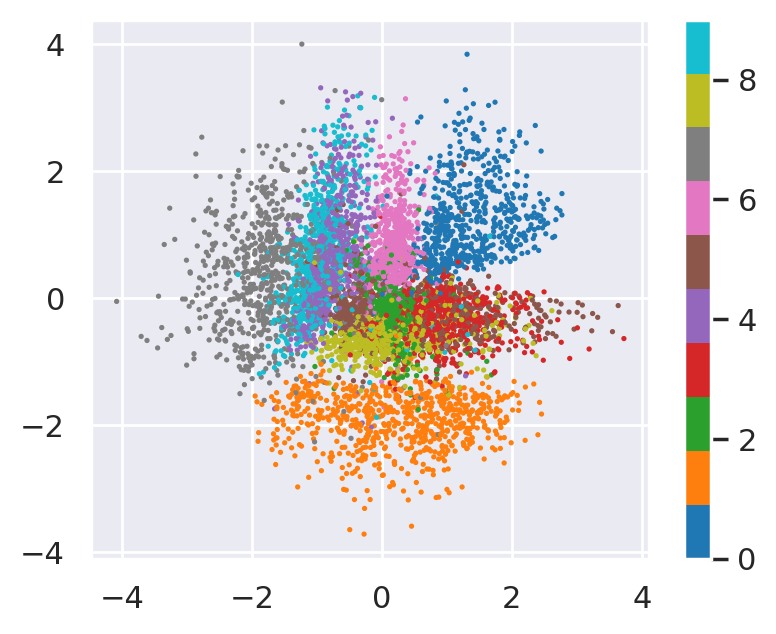

In [ ]:
plot_latent(vae_lr_2, data)

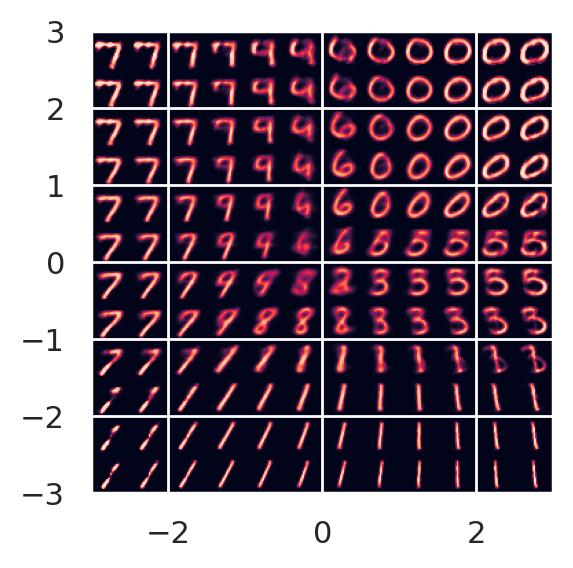

In [ ]:
plot_reconstructed(vae_lr_2, r0=(-3, 3), r1=(-3, 3))

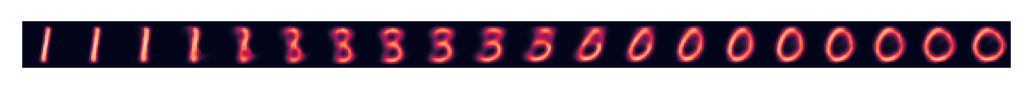

In [ ]:
x, y = next(iter(data))
x_1 = x[y == 1][1].to(device)
x_2 = x[y == 0][1].to(device)

interpolate(vae_lr_2, x_1, x_2, n=20)

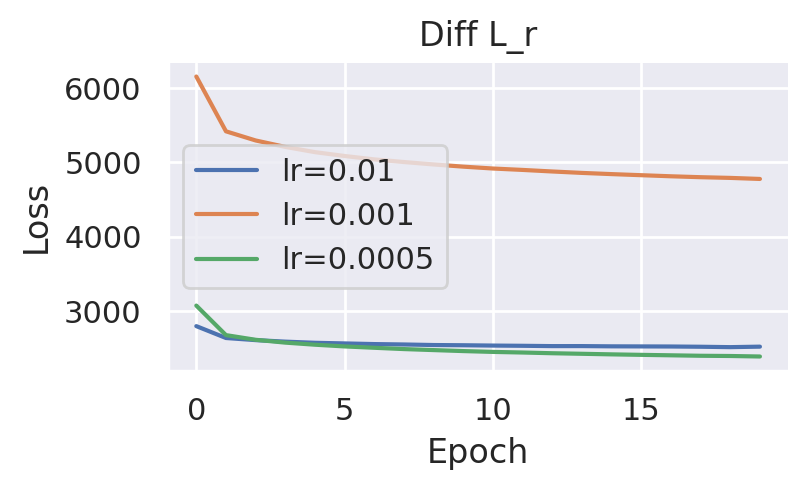

In [ ]:
plt.figure(figsize=(4, 2))
sns.set(style="darkgrid")

sns.lineplot(x=range(20), y=loses_lr_1, label='lr=0.01')
sns.lineplot(x=range(20), y=loses_e_20, label='lr=0.001')
sns.lineplot(x=range(20), y=loses_lr_2, label='lr=0.0005')

sns.despine()

plt.title('Diff L_r')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Base Autoencoder (AE)

In [ ]:
class Encoder(nn.Module):
    def __init__(self, latent_dims):
        super(Encoder, self).__init__()
        self.input_to_hidden = nn.Linear(784, 512)
        self.hidden_to_latent = nn.Linear(512, latent_dims)

    def forward(self, x):
        x = torch.flatten(x, start_dim=1)
        z = self.input_to_hidden(x)
        z = nn.functional.relu(z)
        z = self.hidden_to_latent(z)
        return z

class Decoder(nn.Module):
    def __init__(self, latent_dims):
        super(Decoder, self).__init__()
        self.linear1 = nn.Linear(latent_dims, 512)
        self.linear2 = nn.Linear(512, 784)

    def forward(self, z):
        z = F.relu(self.linear1(z))
        z = torch.sigmoid(self.linear2(z))
        return z.reshape((-1, 1, 28, 28))

In [ ]:
class BaseAutoencoder(nn.Module):
    def __init__(self, latent_dims):
        super(BaseAutoencoder, self).__init__()
        self.encoder = Encoder(latent_dims)
        self.decoder = Decoder(latent_dims)

    def forward(self, x):
        z = self.encoder(x)
        return self.decoder(z)

In [ ]:
def train(autoencoder, data, epochs=20):
    opt = torch.optim.Adam(autoencoder.parameters(), lr=0.001)
    losses = []
    for epoch in range(epochs):
        loss_list = np.array([])
        for x, y in data:
            x = x.to(device)
            opt.zero_grad()
            x_hat = autoencoder(x)
            loss = ((x - x_hat)**2).sum()
            loss.backward()
            opt.step()
            loss_list = np.append(loss_list, loss.item())
        print(f"Epoch [{epoch+1}/{epochs}], avg_loss: {np.mean(loss_list):.4f}")
        losses.append(round(np.mean(loss_list), 4))
    return autoencoder, losses

In [ ]:
ae = BaseAutoencoder(latent_dims).to(device)
ae, loses_ae = train(ae, data)

Epoch [1/20], avg_loss: 2640.5153
Epoch [2/20], avg_loss: 2314.3999
Epoch [3/20], avg_loss: 2234.2145
Epoch [4/20], avg_loss: 2182.6172
Epoch [5/20], avg_loss: 2147.1216
Epoch [6/20], avg_loss: 2118.5477
Epoch [7/20], avg_loss: 2095.1798
Epoch [8/20], avg_loss: 2076.6666
Epoch [9/20], avg_loss: 2059.1336
Epoch [10/20], avg_loss: 2044.2447
Epoch [11/20], avg_loss: 2030.7872
Epoch [12/20], avg_loss: 2020.5705
Epoch [13/20], avg_loss: 2008.9387
Epoch [14/20], avg_loss: 1999.1848
Epoch [15/20], avg_loss: 1991.5581
Epoch [16/20], avg_loss: 1982.7676
Epoch [17/20], avg_loss: 1975.5891
Epoch [18/20], avg_loss: 1968.7603
Epoch [19/20], avg_loss: 1963.1598
Epoch [20/20], avg_loss: 1956.6863


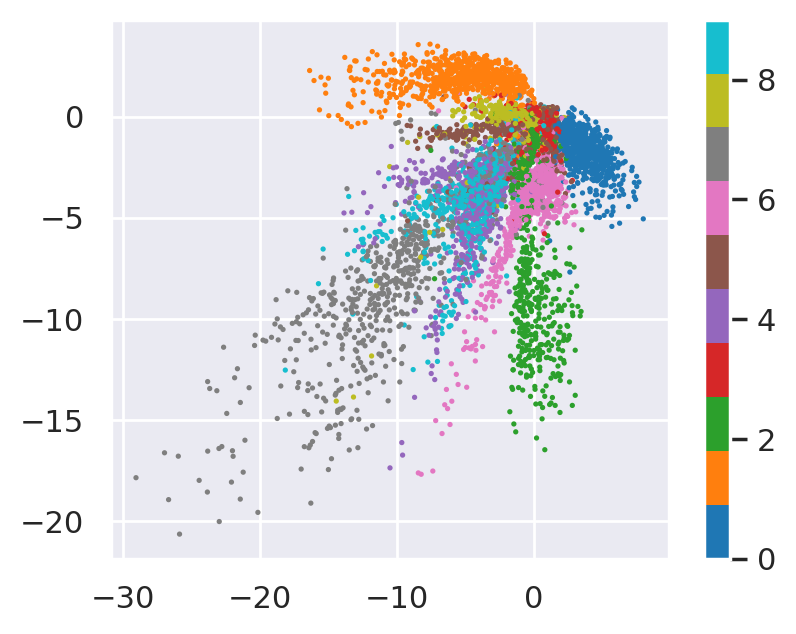

In [ ]:
plot_latent(ae, data)

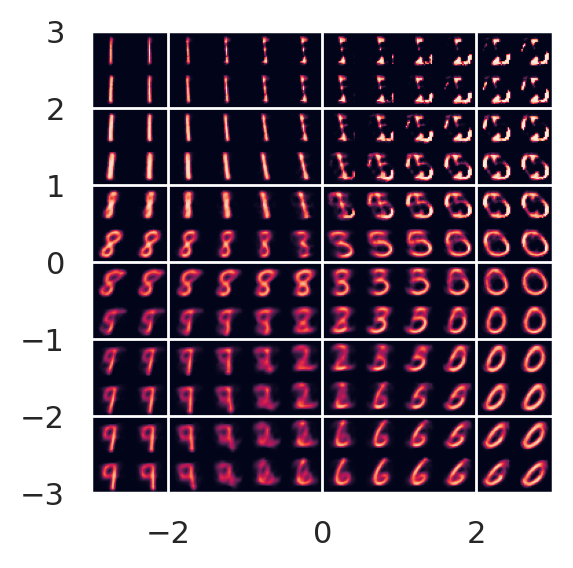

In [ ]:
plot_reconstructed(ae, r0=(-3, 3), r1=(-3, 3))

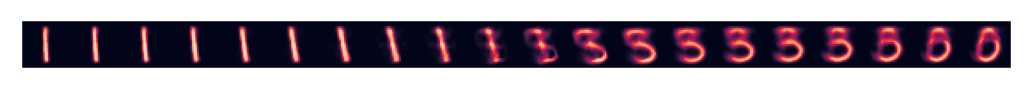

In [ ]:
x, y = next(iter(data))
x_1 = x[y == 1][1].to(device)
x_2 = x[y == 0][1].to(device)

interpolate(ae, x_1, x_2, n=20)

# BVAE

In [ ]:
class BetaVariationalEncoder(nn.Module):
    def __init__(self, latent_dims, beta):
        super(BetaVariationalEncoder, self).__init__()
        self.linear1 = nn.Linear(784, 512)
        self.linear2 = nn.Linear(512, latent_dims)
        self.linear3 = nn.Linear(512, latent_dims)

        self.N = torch.distributions.Normal(0, 1)
        # umożliwienie próbkowania wielowymiarowego rozkładu na karcie graficznej
        self.N.loc = self.N.loc.cuda() if torch.cuda.is_available() else self.N.loc
        self.N.scale = self.N.scale.cuda() if torch.cuda.is_available() else self.N.scale
        self.kl = 0
        self.beta = beta
        self.kl = 0

    def forward(self, x):
        x = torch.flatten(x, start_dim=1)
        x = F.relu(self.linear1(x))
        mu = self.linear2(x)
        sigma = torch.exp(self.linear3(x))
        z = mu + sigma * self.N.sample(mu.shape)
        self.kl = self.beta * (((sigma**2 + mu**2) / 2 - torch.log(sigma) - 1/2).sum())
        return z

class BetaDecoder(nn.Module):
    def __init__(self, latent_dims):
        super(BetaDecoder, self).__init__()
        self.linear1 = nn.Linear(latent_dims, 512)
        self.linear2 = nn.Linear(512, 784)

    def forward(self, z):
        z = F.relu(self.linear1(z))
        z = torch.sigmoid(self.linear2(z))
        return z.reshape((-1, 1, 28, 28))

In [ ]:
class BetaVariationalAutoencoder(nn.Module):
    def __init__(self, latent_dims, beta):
        super(BetaVariationalAutoencoder, self).__init__()
        self.encoder = BetaVariationalEncoder(latent_dims, beta)
        self.decoder = BetaDecoder(latent_dims)

    def forward(self, x):
        z = self.encoder(x)
        return self.decoder(z)

In [ ]:
def train(autoencoder, data, epochs=20, beta=1.0):
    opt = torch.optim.Adam(autoencoder.parameters())
    losses = []
    for epoch in range(epochs):
        loss_list = np.array([])
        for x, y in data:
            x = x.to(device)
            opt.zero_grad()
            x_hat = autoencoder(x)

            reconstruction_loss = ((x - x_hat)**2).sum()
            kl_loss = autoencoder.encoder.kl
            loss = reconstruction_loss + beta * kl_loss

            loss.backward()
            opt.step()
            loss_list = np.append(loss_list, loss.item())

        print(f"Epoch [{epoch+1}/{epochs}], avg_loss: {np.mean(loss_list):.4f}")
        losses.append(round(np.mean(loss_list), 4))

    return autoencoder, losses


##B=0.5

In [ ]:
bvae = BetaVariationalAutoencoder(latent_dims, beta=0.5).to(device)
bvae, loses_bvae = train(bvae, data)

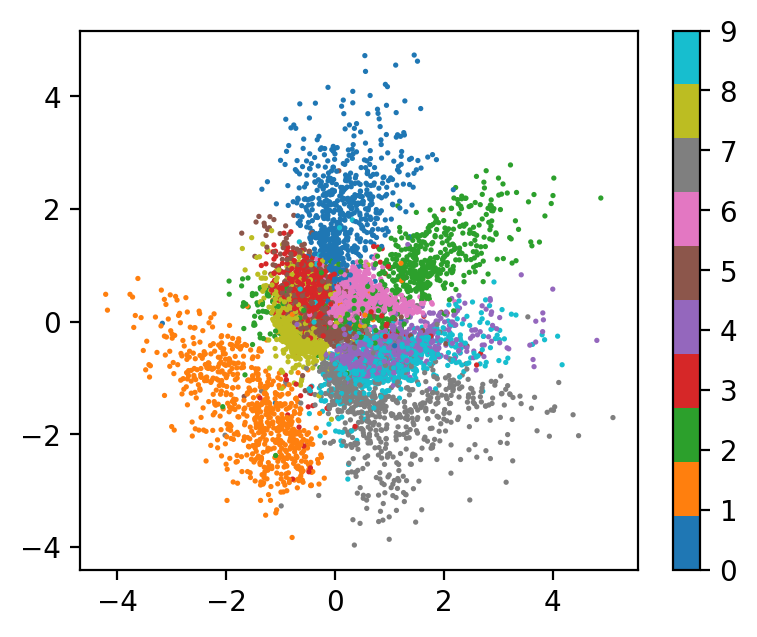

In [ ]:
plot_latent(bvae, data)

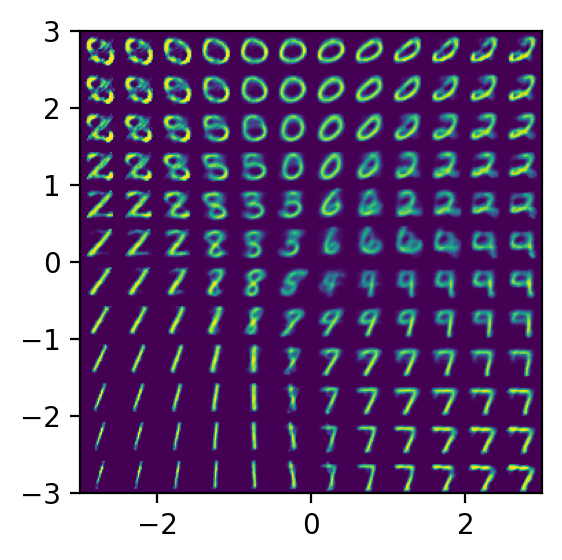

In [ ]:
plot_reconstructed(bvae, r0=(-3, 3), r1=(-3, 3))

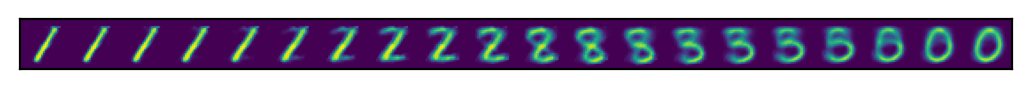

In [ ]:
x, y = next(iter(data))
x_1 = x[y == 1][1].to(device)
x_2 = x[y == 0][1].to(device)

interpolate(bvae, x_1, x_2, n=20)

##B=0.8

In [ ]:
bvae = BetaVariationalAutoencoder(latent_dims, beta=0.8).to(device)
bvae, loses_bvae = train(bvae, data)

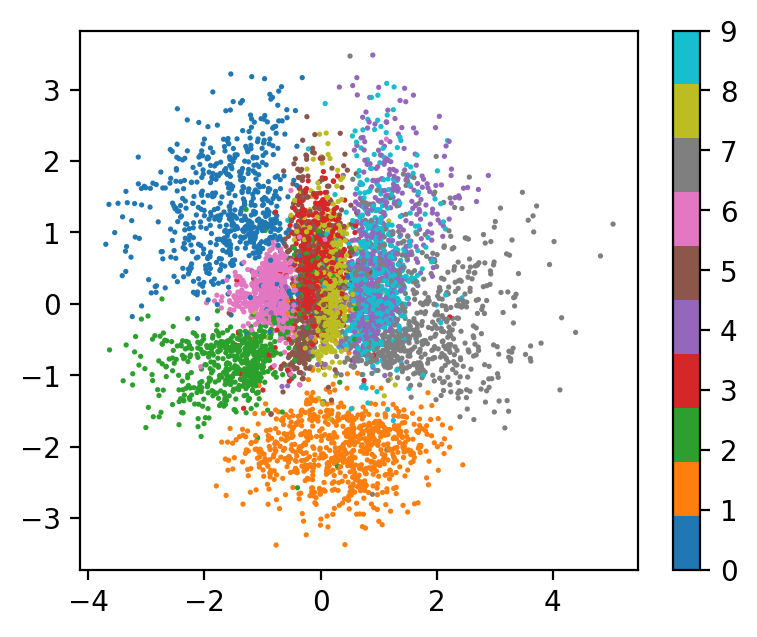

In [ ]:
plot_latent(bvae, data)

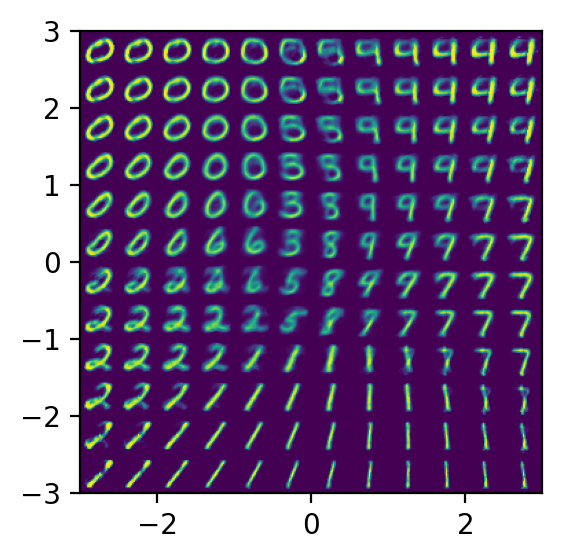

In [ ]:
plot_reconstructed(bvae, r0=(-3, 3), r1=(-3, 3))

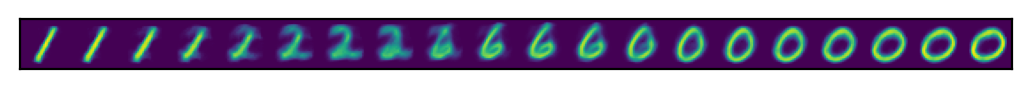

In [ ]:
x, y = next(iter(data))
x_1 = x[y == 1][1].to(device)
x_2 = x[y == 0][1].to(device)

interpolate(bvae, x_1, x_2, n=20)

##B=2

In [ ]:
bvae = BetaVariationalAutoencoder(latent_dims, beta=2).to(device)
bvae, loses_bvae = train(bvae, data)

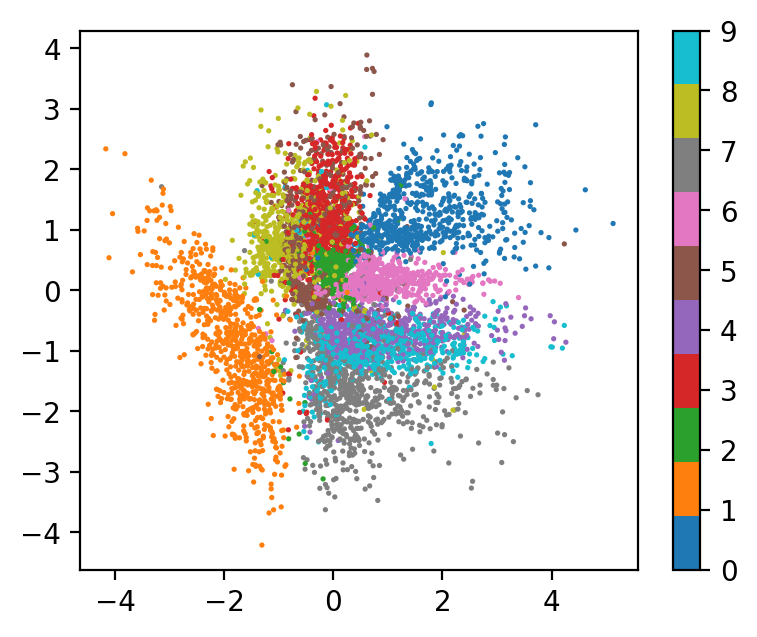

In [ ]:
plot_latent(bvae, data)

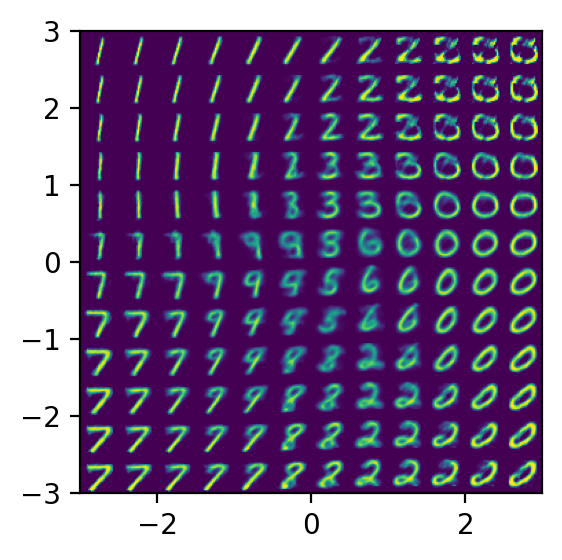

In [ ]:
plot_reconstructed(bvae, r0=(-3, 3), r1=(-3, 3))

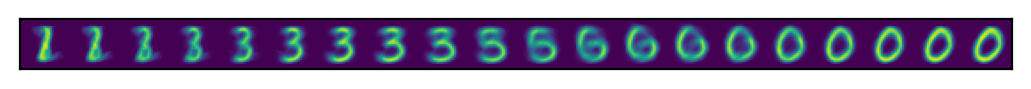

In [ ]:
x, y = next(iter(data))
x_1 = x[y == 1][1].to(device)
x_2 = x[y == 0][1].to(device)

interpolate(bvae, x_1, x_2, n=20)

#Walidacja

In [ ]:
def get_latent(autoencoder, data, cl, num_batches=100):
    latents = []
    for i, (x, y) in tqdm(enumerate(data)):
        mask = (y == cl)
        x = x[mask]
        y = y[mask]

        z = autoencoder.encoder(x.to(device))
        z = z.to('cpu').detach().numpy()
        latents.append(z)

    return np.concatenate(latents, axis=0)


In [ ]:
ae_5 = get_latent(ae, data, 5)
ae_9 = get_latent(ae, data, 9)

0it [00:00, ?it/s]

0it [00:00, ?it/s]

In [ ]:
vae_5 = get_latent(vae, data, 5)
vae_9 = get_latent(vae, data, 9)

0it [00:00, ?it/s]

0it [00:00, ?it/s]

In [ ]:
bvae_5 = get_latent(bvae, data, 5)
bvae_9 = get_latent(bvae, data, 9)

0it [00:00, ?it/s]

0it [00:00, ?it/s]

In [ ]:
df_vae5 = pd.DataFrame(vae_5, columns=["x", "y"])
df_vae5["class"] = 'vae 5'

df_vae9 = pd.DataFrame(vae_9, columns=["x", "y"])
df_vae9["class"] = 'vae 9'

df_bvae5 = pd.DataFrame(bvae_5, columns=["x", "y"])
df_bvae5["class"] = 'bvae 5'

df_bvae9 = pd.DataFrame(bvae_9, columns=["x", "y"])
df_bvae9["class"] = 'bvae 9'

df_ae5 = pd.DataFrame(ae_5, columns=["x", "y"])
df_ae5["class"] = 'ae 5'

df_ae9 = pd.DataFrame(ae_9, columns=["x", "y"])
df_ae9["class"] = 'ae 9'

In [ ]:
df = pd.concat([df_vae5, df_vae9, df_bvae5, df_bvae9, df_ae5, df_ae9], ignore_index=True)

fig = px.scatter(df, x="x", y="y", color="class", title="Porównanie osadzeń 5 i 9")
fig.update_traces(marker=dict(size=5, opacity=0.6), selector=dict(mode='markers'))

fig.show()

In [ ]:
df_loss = pd.DataFrame({'VAE': loses_vae, 'BVAE': loses_bvae, 'AE': loses_ae})

In [ ]:
fig = px.line(df_loss, title="Porównanie strat modeli", width=900)
fig.update_xaxes(title_text='Epoka')
fig.update_yaxes(title_text='Strata')
fig.show()